In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import torch
from cot.data import BinaryCopy, Parity
from cot.config import CHECK_DIR
from cot.models import TransformerConfig, Transformer

WIDTH = 5.5            # inches (from ICML style file)
HEIGHT = 5.5 / 1.5     # golden ratio


rc('font', family='serif', size=8)
usetex = not subprocess.run(['which', 'pdflatex']).returncode
rc('text', usetex=usetex)
if usetex:
    rc('text.latex', preamble=r'\usepackage{times}')

/home/vivc/.local/share/texlive/2022/bin/x86_64-linux/pdflatex


Looking at the evaluation metrics

In [3]:
check_dir = CHECK_DIR / 'a14aa716-0a1b-48dd-8c5d-4a0b785e4843'
# check_dir = CHECK_DIR / 'de8d90eb-7d5d-4a97-8a00-e58d418da722'
checkpoint = torch.load(check_dir / 'model.pth', map_location='cpu')

timestamps = checkpoint['timestamps']
ind = timestamps != -1
timestamps = timestamps[ind]

meaning = checkpoint['meaning']
evals = checkpoint['evals'][ind]

eval_dim = evals.shape[1] // 2
train_evals = evals[:, :eval_dim]
test_evals = evals[:, eval_dim:]

In [4]:
min_len = 8
n_len = 32
nd_meaning = np.array(meaning)
res = np.empty((2, n_len - min_len), dtype=float)
for i, eval_prefix in enumerate(['attn0_peaky_thres', 'attn1_peaky_thres']):
    for j, length in enumerate(range(min_len, n_len)):
        eval_name = f"{eval_prefix}_{length}"

        ind = np.argmax(np.array(meaning) == eval_name)

        train_res = train_evals[-1, ind]
        test_res = test_evals[-1, ind]
        res[i, j] = test_res
res = res.mean(axis=0)

In [5]:
print(res)

[0.9375     0.94444444 0.95       0.95454545 0.95833333 0.96153846
 0.96428571 0.96666667 0.96875    0.97058824 0.97222222 0.97368421
 0.975      0.97619048 0.97727273 0.97826087 0.97916667 0.98
 0.98076923 0.98148148 0.98214286 0.98275862 0.98333333 0.98387097]


Looking at the model attention maps

In [6]:
token_emb = checkpoint['model_state_dict']['embeddings.token_emb.weight'].cpu()
pos_emb = checkpoint['model_state_dict']['embeddings.pos_emb.weight'].cpu()

In [7]:
lengths = list(np.arange(n_len) + 1)

problem = 'parity'
if problem == 'binary-copy':
    testset = BinaryCopy()
elif problem == 'parity':
    testset = Parity()
testset.set_data(lengths, data_type="test")

In [8]:
config = TransformerConfig(
    vocab_size=torch.max(testset.data).item() + 1,
    emb_dim=128,
    pos_emb=True,
    seq_len=len(testset[0]),
    emb_dropout=0,
    n_head=1,
    n_layer=2,
)

model = Transformer(config)
model.load_state_dict(checkpoint["model_state_dict"])
# model.to(device=device)
model.eval()

i = -2000
sequence = testset.data[i:i + 1]
# sequence = sequence.to(device=device, dtype=torch.long)

with torch.no_grad():
    logits, attentions = model(sequence, verbose=True)
attn0 = attentions[0, 0, 0].cpu()
attn1 = attentions[1, 0, 0].cpu()

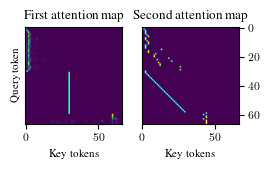

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(.5 * WIDTH, .5 * HEIGHT))
axes[0].imshow(attn0)
axes[1].imshow(attn1 > .5)
axes[0].set_title('First attention map')
axes[1].set_title('Second attention map')
axes[0].set_xlabel('Key tokens')
axes[1].set_xlabel('Key tokens')
axes[0].set_ylabel('Query token')
axes[0].set_yticks([])
axes[1].yaxis.tick_right()
fig.savefig('attention_map.pdf', bbox_inches="tight")

Let us now focus on some training dynamics curve.

In [10]:
check_dir = CHECK_DIR / '590d57e0-c357-450b-a16e-1b5ef14bd1ba'
checkpoint = torch.load(check_dir / 'model.pth', map_location='cpu')

timestamps = checkpoint['timestamps']
ind = timestamps != -1
timestamps = timestamps[ind]

meaning = checkpoint['meaning']
evals = checkpoint['evals'][ind]

eval_dim = evals.shape[1] // 2
train_evals = evals[:, :eval_dim]
test_evals = evals[:, eval_dim:]

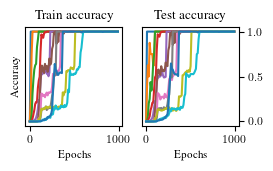

In [11]:
i = 100
fig, axes = plt.subplots(1, 2, figsize=(.5 * WIDTH, .35 * HEIGHT))
axes[0].plot(timestamps[:i], train_evals[:i, :n_len:3])
axes[1].plot(timestamps[:i], test_evals[:i, :n_len:3])
axes[0].set_title('Train accuracy')
axes[1].set_title('Test accuracy')
axes[0].set_xlabel('Epochs')
axes[1].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_yticks([])
axes[1].yaxis.tick_right()
fig.savefig('evals.pdf', bbox_inches="tight")